# **Music Recommendation System**

# **Milestone 2**

Now that we have explored the data, let's apply different algorithms to build recommendation systems.

**Note:** Use the shorter version of the data, i.e., the data after the cutoffs as used in Milestone 1.

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# To compute the cosine similarity between two vectors
from sklearn.metrics.pairwise import cosine_similarity

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

## **Load the dataset**

In [ ]:
# Load the dataset you have saved at the end of milestone 1
df_final = pd.read_csv('/content/drive/MyDrive/ADSP/df_final.csv')


In [ ]:
df_final.head(20)

,user_id,song_id,play_count,title,release,artist_name,year
0,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
1,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
2,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
3,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
4,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007
5,6958,892,1,Bleeding Hearts,Hell Train,Soltero,0
6,6958,1050,5,Wet Blanket,Old World Underground_ Where Are You Now?,Metric,2003
7,6958,1480,1,Fast As I Can,Monday Morning Cold,Erin McKeown,2000
8,6958,1671,2,Sleeping In (Album),Give Up,Postal Service,2003
9,6958,1752,1,Gimme Sympathy,Gimme Sympathy,Metric,2009


### **Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems based on the sum of play counts.

In [ ]:
# Calculating average play_count
average_count = df_final.groupby('song_id').mean()['play_count']        # Hint: Use groupby function on the song_id column

# Calculating the frequency a song is played
play_freq = df_final.groupby('song_id').count()['play_count']        # Hint: Use groupby function on the song_id column




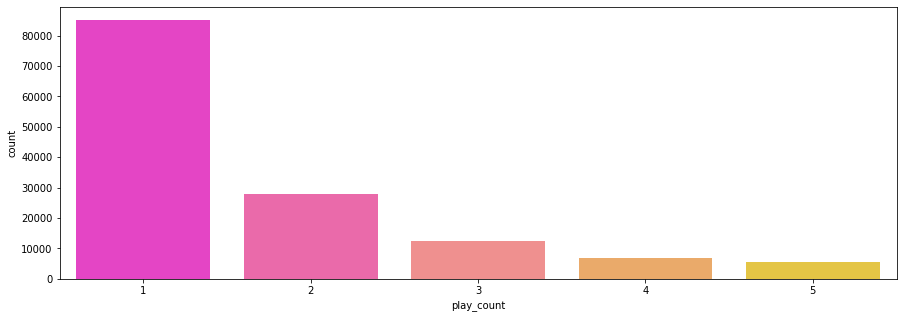

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(df_final["play_count"], palette = 'spring')

In [ ]:
print(average_count)

song_id
21      1.631387
22      1.464286
50      1.616822
52      1.715232
62      1.727273
          ...   
9939    1.673640
9942    2.484277
9960    1.598592
9981    1.900621
9989    1.336066
Name: play_count, Length: 620, dtype: float64


In [ ]:
print(play_freq)

song_id
21      274
22      140
50      107
52      453
62      121
       ... 
9939    239
9942    159
9960    142
9981    161
9989    122
Name: play_count, Length: 620, dtype: int64


In [ ]:
# Making a dataframe with the average_count and play_freq
final_play = pd.DataFrame({'avg_count': average_count, 'play_freq':play_freq})

# Let us see the first five records of the final_play dataset
final_play.head()

,avg_count,play_freq
song_id,,
21,1.631387,274
22,1.464286,140
50,1.616822,107
52,1.715232,453
62,1.727273,121


Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [ ]:
# Build the function to find top n songs
# It gives top n songs among those being played for more than min_playcounts
def top_n_songs(data, n, min_playcounts = 100):
    
    # Finding songs with interactions greater than the minimum number of playcounts
    recommendations = data[data['play_freq'] > min_playcounts]
    
    # Sorting values with respect to the average count
    recommendations = recommendations.sort_values(by = 'avg_count', ascending = False)
    
    return recommendations.index[:n]

In [ ]:
# Recommend top 10 songs using the function defined above
list(top_n_songs(final_play, 10))


[7224, 6450, 8324, 9942, 8483, 5531, 657, 5653, 614, 2220]

### **User User Similarity-Based Collaborative Filtering**

To build the user-user-similarity-based and subsequent models we will use the "surprise" library.

In [ ]:
# Install the surprise package using pip. Uncomment and run the below code to do the same
!pip install surprise 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import necessary libraries

# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

### Some useful functions

Below is the function to calculate precision@k and recall@k, RMSE and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?

In [ ]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(model, k = 30, threshold = 1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_playcount in user_est_true.items():

        # Sort user ratings by estimated value
        user_playcount.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_playcount)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_playcount[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_playcount[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)
    
    # Formula to compute the F-1 score
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by changing the threshold? What is the intuition behind using the threshold value of 1.5? 

In [ ]:
# Instantiating Reader scale with expected rating scale 
reader = Reader(rating_scale=(0, 5)) #use rating scale (0, 5)

# Loading the dataset
data = Dataset.load_from_df(df_final[["user_id", "song_id", "play_count"]], reader) # Take only "user_id","song_id", and "play_count"

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.4, random_state = 42) # Take test_size = 0.4


**Think About It:** How changing the test size would change the results and outputs?

In [ ]:
# Build the default user-user-similarity model
sim_options = {'name': 'cosine',
               'user_based':True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1) # Use random_state = 1 

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 30
precision_recall_at_k(sim_user_user) # Use sim_user_user model




RMSE: 1.0817
Precision:  0.401
Recall:  0.705
F_1 score:  0.511


**Observations and Insights:_________**

In [ ]:
# Predicting play_count for a sample user with a listened song
sim_user_user.predict(6958, 1671, r_ui = 2, verbose = True) # Use user id 6958 and song_id 1671


user: 6958       item: 1671       r_ui = 2.00   est = 1.72   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.7227331119335394, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
# Predicting play_count for a sample user with a song not-listened by the user
sim_user_user.predict(6958, 3232, verbose = True) # Use user_id 6958 and song_id 3232



user: 6958       item: 3232       r_ui = None   est = 1.68   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.6776559989382887, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:_________**

Now, let's try to tune the model and see if we can improve the model performance.

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine", 'pearson', "pearson_baseline"],
                              'user_based': [True], "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data) # Use entire data for GridSearch

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


1.0023059334615017
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}


In [ ]:
# Train the best model found in above gridsearch
# Using the optimal similarity measure for user-user collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'user_based': True,
               'min_support': 2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 30
precision_recall_at_k(sim_user_user_optimized)



RMSE: 1.0136
Precision:  0.443
Recall:  0.736
F_1 score:  0.553


**Observations and Insights:_________**

In [ ]:
# Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui = 2
sim_user_user_optimized.predict(6958, 1671, r_ui = 2, verbose = True)



user: 6958       item: 1671       r_ui = 2.00   est = 1.95   {'actual_k': 24, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.9453672719637054, details={'actual_k': 24, 'was_impossible': False})

In [ ]:
# Predict the play count for a song that is not listened to by the user (with user_id 6958)
sim_user_user_optimized.predict(6958, 3232, verbose = True)


user: 6958       item: 3232       r_ui = None   est = 1.70   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.698939503494818, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations and Insights:______________**

**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain song?

In [ ]:
# Use inner id 0
list(trainset.all_items()[:5])

[0, 1, 2, 3, 4]

In [ ]:
#get_neighbors(iid, k)
sim_user_user_optimized.get_neighbors(0, k = 5)


[693, 27, 1387, 760, 1799]

Below we will be implementing a function where the input parameters are:

- data: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- top_n: The **number of songs we want to recommend**
- algo: The algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'song_id', values = 'play_count')

    # Extracting those business ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the business ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x : x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user


In [ ]:
# Make top 5 recommendations for user_id 6958 with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 6958, 5, sim_user_user_optimized)



In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['song_id', 'predicted_ratings'])



,song_id,predicted_ratings
0,3165,2.652562
1,6716,2.638973
2,9019,2.626063
3,1348,2.605952
4,4134,2.532803


**Observations and Insights:______________**

### Correcting the play_counts and Ranking the above songs

In [ ]:
def ranking_songs(recommendations, final_rating):
  # Sort the songs based on play counts
  ranked_songs = final_rating.loc[[items[0] for items in recommendations]].sort_values('play_freq', ascending = False)[['play_freq']].reset_index()

  # Merge with the recommended songs to get predicted play_count
  ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns = ['song_id', 'predicted_ratings']), on = 'song_id', how = 'inner')

  # Rank the songs based on corrected play_counts
  ranked_songs['corrected_ratings'] = ranked_songs['predicted_ratings'] - 1 / np.sqrt(ranked_songs['play_freq'])

  # Sort the songs based on corrected play_counts
  ranked_songs = ranked_songs.sort_values('corrected_ratings', ascending = False)
  
  return ranked_songs


 

**Think About It:** In the above function to correct the predicted play_count a quantity 1/np.sqrt(n) is subtracted. What is the intuition behind it? Is it also possible to add this quantity instead of subtracting?

In [ ]:
# Applying the ranking_songs function on the final_play data
ranking_songs(recommendations, final_play)


,song_id,play_freq,predicted_ratings,corrected_ratings
2,3165,368,2.652562,2.600433
1,9019,464,2.626063,2.579639
3,6716,188,2.638973,2.566040
0,1348,487,2.605952,2.560638
4,4134,139,2.532803,2.447984


**Observations and Insights:______________**

### Item Item Similarity-based collaborative filtering recommendation systems 

In [ ]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# The KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)


RMSE: 1.0320
Precision:  0.316
Recall:  0.572
F_1 score:  0.407


**Observations and Insights:______________**

In [ ]:
# Predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user
sim_item_item.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.37   {'actual_k': 18, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.3695958289911163, details={'actual_k': 18, 'was_impossible': False})

In [ ]:
# Predict the play count for a user that has not listened to the song (with song_id 1671)
sim_item_item.predict(6958, 3232, verbose = True)


user: 6958       item: 3232       r_ui = None   est = 1.36   {'actual_k': 18, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.3565368486337936, details={'actual_k': 18, 'was_impossible': False})

**Observations and Insights:______________**

In [ ]:
# Apply grid search for enhancing model performance

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine", 'pearson', "pearson_baseline"],
                              'user_based': [False], "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Extract the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



0.9899982911140423
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}}


**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

In [ ]:
# Apply the best model found in the grid search
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'user_based': False,
               'min_support': 2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 30
precision_recall_at_k(sim_item_item_optimized)

RMSE: 1.0016
Precision:  0.441
Recall:  0.676
F_1 score:  0.534


**Observations and Insights:______________**

In [ ]:
# Predict the play_count by a user(user_id 6958) for the song (song_id 1671)
sim_item_item_optimized.predict(6958, 1671, r_ui = 2, verbose = True)


user: 6958       item: 1671       r_ui = 2.00   est = 2.06   {'actual_k': 6, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=2.0566954344862127, details={'actual_k': 6, 'was_impossible': False})

In [ ]:
# Predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user
sim_item_item_optimized.predict(6958, 3232, verbose = True)


user: 6958       item: 3232       r_ui = None   est = 1.15   {'actual_k': 9, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.1533222731105461, details={'actual_k': 9, 'was_impossible': False})

**Observations and Insights:______________**

In [ ]:
# Find five most similar items to the item with inner id 0
#see following 2 code cells

In [ ]:
list(trainset.all_items()[:20])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
#get_neighbors(iid, k)
sim_item_item_optimized.get_neighbors(iid = 0, k = 5)


[199, 166, 196, 288, 10]

In [ ]:
# Making top 5 recommendations for user_id 6958 with item_item_similarity-based recommendation engine
recommendations = get_recommendations(df_final, 6958, 5, sim_item_item_optimized)


In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"

pd.DataFrame(recommendations, columns = ['song_id', 'predicted_play_count'])


,song_id,predicted_play_count
0,5916,2.456086
1,8702,2.294603
2,771,2.211782
3,1089,2.207878
4,731,2.173502


In [ ]:
# Applying the ranking_songs function
ranking_songs(recommendations, final_play)


,song_id,play_freq,predicted_ratings,corrected_ratings
1,5916,178,2.456086,2.381133
2,8702,168,2.294603,2.217452
0,771,198,2.211782,2.140715
3,1089,143,2.207878,2.124254
4,731,140,2.173502,2.088986


**Observations and Insights:_________**

### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

In [ ]:
# Build baseline model using svd
# Using SVD with matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the training dataset
svd.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd)


RMSE: 1.0026
Precision:  0.432
Recall:  0.654
F_1 score:  0.52


In [ ]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2
svd.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.33   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.333024307816353, details={'was_impossible': False})

In [ ]:
# Making a prediction for the user who has not listened to the song (song_id 3232)
svd.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.30   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.2983047805615977, details={'was_impossible': False})

#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performe 3-fold grid-search cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


1.0032690630062486
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).

In [ ]:
# Building the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 30
precision_recall_at_k(svd_optimized)

RMSE: 1.0085
Precision:  0.414
Recall:  0.645
F_1 score:  0.504


**Observations and Insights:_________**

In [ ]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671
svd_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.28   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.2838400390467515, details={'was_impossible': False})

In [ ]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
svd_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.40   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.3997025482649295, details={'was_impossible': False})

**Observations and Insights:_________**

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, 6958, 5, svd_optimized)

In [ ]:
# Ranking songs based on above recommendations
ranking_songs(svd_recommendations, final_play)


,song_id,play_freq,predicted_ratings,corrected_ratings
4,7224,109,2.811510,2.715727
2,6450,110,2.183207,2.087861
3,5653,110,2.112904,2.017557
0,5531,664,1.974058,1.935250
1,9942,159,1.990067,1.910762


**Observations and Insights:_________**

### Cluster Based Recommendation System

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [ ]:
# Make baseline clustering model
# Using CoClustering algorithm
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the train set
clust_baseline.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 30
precision_recall_at_k(clust_baseline)

RMSE: 1.0428
Precision:  0.398
Recall:  0.594
F_1 score:  0.477


In [ ]:
# Making prediction for user_id 6958 and song_id 1671
clust_baseline.predict(6958, 1671, r_ui = 2, verbose = True)


user: 6958       item: 1671       r_ui = 2.00   est = 1.36   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.3627795906030837, details={'was_impossible': False})

In [ ]:
# Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user
clust_baseline.predict(6958, 3232, verbose = True)


user: 6958       item: 3232       r_ui = None   est = 1.55   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.5488944215348255, details={'was_impossible': False})

#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [ ]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [5, 6, 7, 8], 'n_cltr_i': [5, 6, 7, 8], 'n_epochs': [10, 20, 30]}

# Performing 3-fold grid search cross-validation
gs = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



1.0496614252853838
{'n_cltr_u': 5, 'n_cltr_i': 7, 'n_epochs': 10}


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [ ]:
# Train the tuned Coclustering algorithm
# Using tuned Coclustering algorithm
clust_tuned = CoClustering(n_cltr_u = 5, n_cltr_i = 6, n_epochs = 10, random_state = 1)

# Training the algorithm on the train set
clust_tuned.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 30
precision_recall_at_k(clust_tuned)

RMSE: 1.0603
Precision:  0.4
Recall:  0.575
F_1 score:  0.472


**Observations and Insights:_________**

In [ ]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671
clust_tuned.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.15   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.1499567251926432, details={'was_impossible': False})

In [ ]:
# Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
clust_tuned.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.10   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.0953712140878151, details={'was_impossible': False})

**Observations and Insights:_________**

#### Implementing the recommendation algorithm based on optimized CoClustering model

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm
clustering_recommendations = get_recommendations(df_final, 6958, 5, clust_tuned)

### Correcting the play_count and Ranking the above songs

In [ ]:
# Ranking songs based on the above recommendations
ranking_songs(clustering_recommendations, final_play)


,song_id,play_freq,predicted_ratings,corrected_ratings
4,7224,109,3.780133,3.684351
3,6450,110,3.063715,2.968369
2,9942,159,2.765679,2.686374
1,614,401,2.613725,2.563787
0,352,802,2.569333,2.534021


**Observations and Insights:_________**

### Content Based Recommendation Systems

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [ ]:
df_small = df_final

In [ ]:
# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"
df_small['text'] = df_small['title'] + ' ' + df_small['release'] + ' ' + df_small['artist_name']

df_small.head()

,user_id,song_id,play_count,title,release,artist_name,year,text
0,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,Daisy And Prudence Distillation Erin McKeown
1,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004,The Ballad of Michael Valentine Sawdust The Ki...
2,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007,I Stand Corrected (Album) Vampire Weekend Vamp...
3,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007,They Might Follow You Tiny Vipers Tiny Vipers
4,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007,Monkey Man You Know I'm No Good Amy Winehouse


In [ ]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_small = df_small[['user_id', 'song_id', 'play_count', 'title', 'text']]

# Drop the duplicates from the title column
df_small = df_small.drop_duplicates(subset = ['title'])

# Set the title column as the index
df_small = df_small.set_index('title')

# See the first 5 records of the df_small dataset
df_small.head()


,user_id,song_id,play_count,text
title,,,,
Daisy And Prudence,6958,447,1,Daisy And Prudence Distillation Erin McKeown
The Ballad of Michael Valentine,6958,512,1,The Ballad of Michael Valentine Sawdust The Ki...
I Stand Corrected (Album),6958,549,1,I Stand Corrected (Album) Vampire Weekend Vamp...
They Might Follow You,6958,703,1,They Might Follow You Tiny Vipers Tiny Vipers
Monkey Man,6958,719,1,Monkey Man You Know I'm No Good Amy Winehouse


In [ ]:
# Create the series of indices from the data
indices = pd.Series(df_small.index)

indices[ : 5]


0                 Daisy And Prudence
1    The Ballad of Michael Valentine
2          I Stand Corrected (Album)
3              They Might Follow You
4                         Monkey Man
Name: title, dtype: object

In [ ]:
# Importing necessary packages to work with text data
import nltk

# Download punkt library
nltk.download("punkt")

# Download stopwords library
nltk.download("stopwords")

# Download wordnet 
nltk.download("wordnet")

nltk.download('omw-1.4')

# Import regular expression
import re

# Import word_tokenizer
from nltk import word_tokenize

# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

# Import stopwords
from nltk.corpus import stopwords

# Import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


We will create a **function to pre-process the text data:**

In [ ]:
# Function to tokenize the text
def tokenize(text):
    
    text = re.sub(r"[^a-zA-Z]"," ", text.lower())
    
    tokens = word_tokenize(text)
    
    words = [word for word in tokens if word not in stopwords.words("english")]  # Use stopwords of english
    
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [ ]:
# Create tfidf vectorizer 
tfidf = TfidfVectorizer(tokenizer = tokenize)

# Fit_transfrom the above vectorizer on the text column and then convert the output into an array
song_tfidf = tfidf.fit_transform(df_small['text'].values).toarray()




In [ ]:
# Compute the cosine similarity for the tfidf above output
similar_songs = cosine_similarity(song_tfidf, song_tfidf)

# Let us see the above array
similar_songs

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.03257364],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.03257364, ..., 0.        , 0.        ,
        1.        ]])

 Finally, let's create a function to find most similar songs to recommend for a given song.

In [ ]:
# Function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):
    
    recommended_songs = []
    
    # Getting the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # Creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_songs[idx]).sort_values(ascending = False)

    # Getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1 : 11].index)
    print(top_10_indexes)
    
    # Populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(df_small.index)[i])
        
    return recommended_songs

Recommending 10 songs similar to Learn to Fly

In [ ]:
# Make the recommendation for the song with title 'Learn To Fly'
recommendations('Learn To Fly', similar_songs)


[445, 520, 246, 465, 367, 429, 0, 416, 417, 418]


['Big Me',
 'Everlong',
 'The Pretender',
 'Nothing Better (Album)',
 'From Left To Right',
 'Lifespan Of A Fly',
 'Daisy And Prudence',
 "Ghosts 'n' Stuff (Original Instrumental Mix)",
 'Closer',
 'No Cars Go']

**Observations and Insights:_________**

## **Conclusion and Recommendations:** 

- **Refined Insights -** What are the most meaningful insights from the data relevant to the problem?

- **Comparison of various techniques and their relative performance -** How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

- **Proposal for the final solution design -** What model do you propose to be adopted? Why is this the best solution to adopt?